# Entendimento de negócio

`Objetivo geral`

- Um banco requisitou um modelo de _machine learning_ para a identificação de clientes em _churn_, buscando encontrar o maior número de clientes em churn possível.

- É necessário entregar, no final, uma lista com os 20 clientes mais prioritários.

### Breve descrição dos dados

Coluna | Descrição
-------|----------
RowNumber | Nº da linha
CustomerId | ID do cliente
Surname | Sobrenome do cliente
CreditScore | Pontuação de crédito do cliente para o mercado de consumo
Geography | País onde o cliente reside
Gender | Gênero do cliente
Age | Idade do cliente
Tenure| Nº de meses que o cliente permaneceu ativo
Balance  | Valor gasto pelo cliente
NumOfProducts | Nº de produtos comprados pelo cliente
HasCrCard | Indica se o cliente possui ou não um cartão de crédito
IsActiveMember | Indica se o cliente ainda tem o cadastro ativo na empresa
EstimatedSalary | Estimativa de salário mensal do cliente
Exited | Indica se o cliente está ou não em churn 

# 1. Bibliotecas

In [1]:
# Manipulação dos dados

import pandas as pd
import numpy as np

# DataViz

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE # Separabilidade dos dados
import scikitplot as skplt # Cumulative gains / Lift
from sklearn.metrics import precision_recall_curve # Gráfico de recall e precisão


# Split dos dados

from sklearn.model_selection import train_test_split

# Pipeline / transformação

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Métricas

from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_curve

# Balanceamento das classes

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

# Modelagem

from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Feature selection

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Otimização dos hiperparâmetros

from sklearn.model_selection import RandomizedSearchCV

# 2. Carregando os dados

In [2]:
df_raw = pd.read_csv('data/churn.csv')

# 3. Inspeção inicial

In [3]:
# Analisando colunas

df_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# Verificando a dimensionalidade

print(f'Total de linhas: {df_raw.shape[0]}')
print(f'Total de colunas: {df_raw.shape[1]}')

Total de linhas: 10000
Total de colunas: 14


In [5]:
# Informações gerais dos dados

df_raw. info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
# Verificando a distribuição geral dos dados

np.round(df_raw.describe(),1)

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,5000.5,15690940.6,650.5,38.9,5.0,76485.9,1.5,0.7,0.5,100090.2,0.2
std,2886.9,71936.2,96.7,10.5,2.9,62397.4,0.6,0.5,0.5,57510.5,0.4
min,1.0,15565701.0,350.0,18.0,0.0,0.0,1.0,0.0,0.0,11.6,0.0
25%,2500.8,15628528.2,584.0,32.0,3.0,0.0,1.0,0.0,0.0,51002.1,0.0
50%,5000.5,15690738.0,652.0,37.0,5.0,97198.5,1.0,1.0,1.0,100193.9,0.0
75%,7500.2,15753233.8,718.0,44.0,7.0,127644.2,2.0,1.0,1.0,149388.2,0.0
max,10000.0,15815690.0,850.0,92.0,10.0,250898.1,4.0,1.0,1.0,199992.5,1.0


In [7]:
# Checando se há dados duplicados

df_raw.duplicated().sum()

0

In [8]:
# Checando se há dados nulos

df_raw.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

# 4. Split do dataset

In [9]:
# Cópia do dataset

df1 = df_raw.copy()

In [10]:
# Separando features de targets

X = df1.drop('Exited', axis=1)
y = df1['Exited']

In [11]:
# Separando os dados em treino, teste e validação

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1, stratify=y_train_val, random_state=42)

In [12]:
# Dimensionalidade

print(f'Dados de treino: {X_train.shape[0]}')
print(f'Dados de validação:{X_val.shape[0]}')
print(f'Dados de teste: {X_test.shape[0]}')

Dados de treino: 8100
Dados de validação:900
Dados de teste: 1000


# 5. EDA

<function matplotlib.pyplot.show(close=None, block=None)>

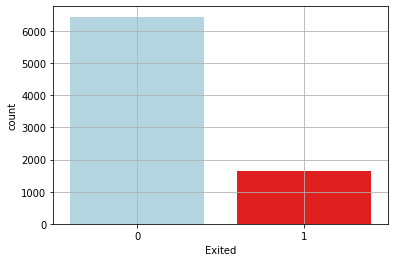

In [13]:
# Verificando se as classes estão desbalanceadas

sns.countplot(data=X_train.join(y_train), x='Exited', palette=['lightblue', 'red'])
plt.grid()
plt.show

In [14]:
# Checando a porcentagem das classes

y_train.value_counts(normalize=True)

0    0.796296
1    0.203704
Name: Exited, dtype: float64

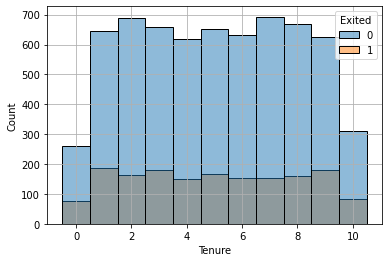

In [15]:
# Churn na quantidade de meses ativos

data = pd.concat([X_train, y_train], axis=1)

sns.histplot(data=data, x='Tenure', hue='Exited', discrete=True)
plt.grid()

In [16]:
# Separando colunas com dados numéricos
colunas_numericas = X_train.join(
    y_train).select_dtypes(include=['int64', 'float64'])

# Separando colunas com dados categóricos
colunas_categoricas = X_train.join(y_train).select_dtypes(
    exclude=['int64', 'float64'])

### 5.1 Dados numéricos

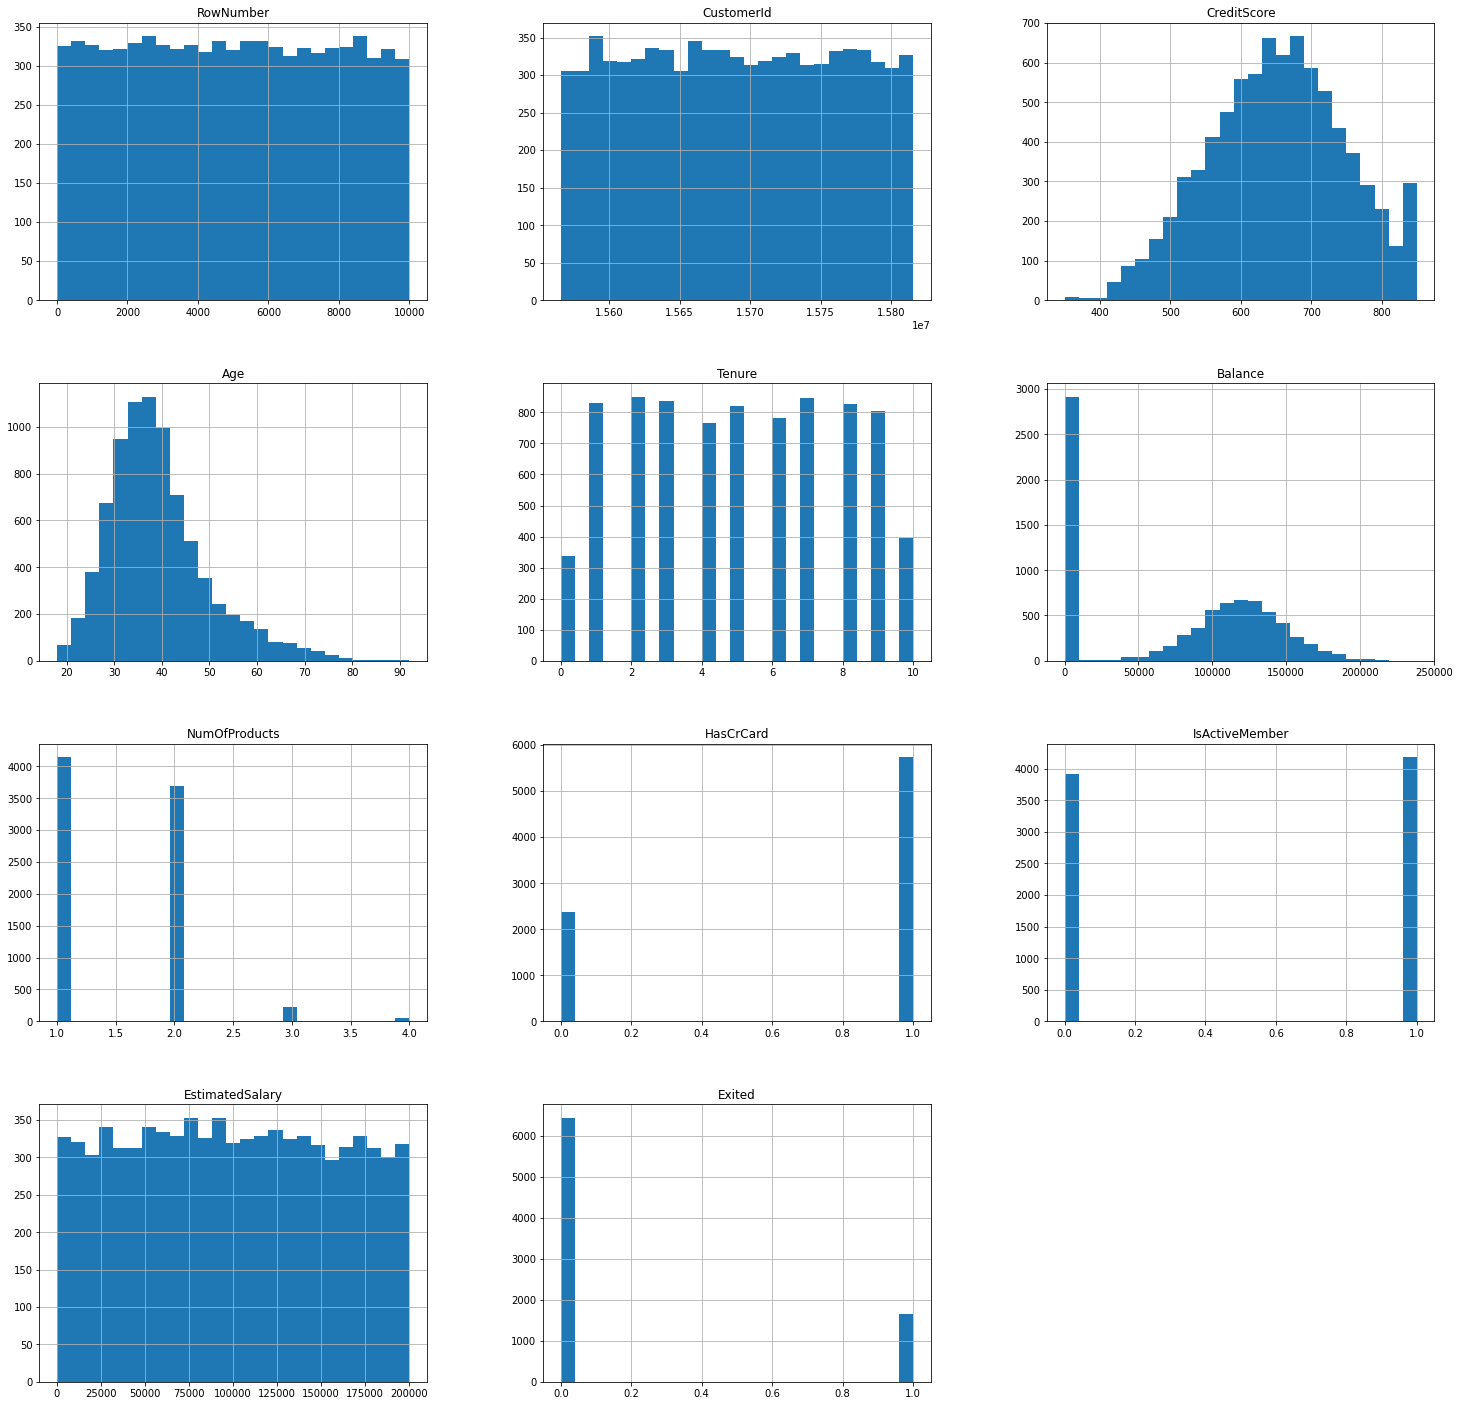

In [17]:
# Checando as distribuições das variáveis numéricas

colunas_numericas.hist(figsize=(25, 25), bins=25);

In [18]:
# Verificando quantidade de clientes ativos

df_raw['IsActiveMember'].value_counts(normalize=True)

1    0.5151
0    0.4849
Name: IsActiveMember, dtype: float64

In [19]:
# Contabilizando clientes com e sem cartão de crédito

df_raw['HasCrCard'].value_counts(normalize=True)

1    0.7055
0    0.2945
Name: HasCrCard, dtype: float64

In [20]:
# Quantidade de clientes por serviço oferecido

df_raw['NumOfProducts'].value_counts(normalize=True)

1    0.5084
2    0.4590
3    0.0266
4    0.0060
Name: NumOfProducts, dtype: float64

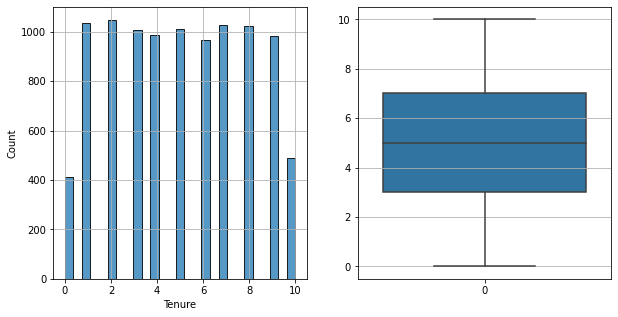

In [21]:
# Tenure (meses com clientes ativos)

plt.figure(figsize=(10, 5))

# Histograma
plt.subplot(1, 2, 1)
sns.histplot(data=df_raw['Tenure'])
plt.grid()

# Boxplot
plt.subplot(1, 2, 2)
plt.grid()
sns.boxplot(data=df_raw['Tenure'])

plt.show()

In [22]:
# Quantos clientes são recém-chegados

(df_raw['Tenure'] == 0).sum()

413

In [23]:
# Porcentagem de clientes por mês que permaneceu ativo

df_raw['Tenure'].value_counts(normalize=True)

2     0.1048
1     0.1035
7     0.1028
8     0.1025
5     0.1012
3     0.1009
4     0.0989
9     0.0984
6     0.0967
10    0.0490
0     0.0413
Name: Tenure, dtype: float64

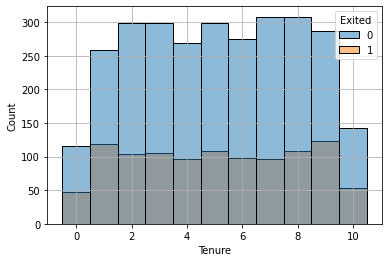

In [24]:
# Meses ativos e churn

sns.histplot(data=X_train.join(y_train)[X_train['IsActiveMember'] == 0], x='Tenure', hue='Exited', discrete=True)
plt.grid()

Não há diferença.

<function matplotlib.pyplot.show(close=None, block=None)>

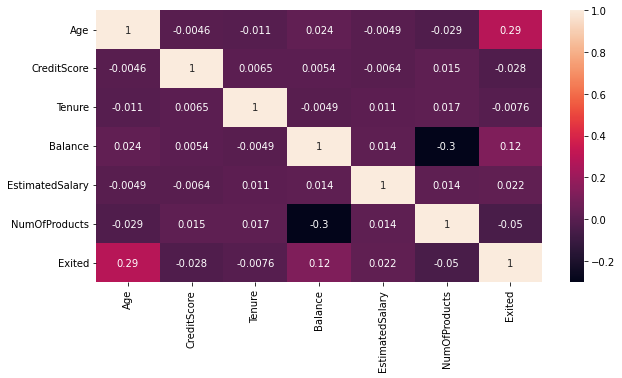

In [25]:
# Correlação linear de Pearson

plt.figure(figsize=(10, 5))

cols = colunas_numericas[['Age', 'CreditScore', 'Tenure',
                          'Balance', 'EstimatedSalary', 'NumOfProducts']].join(y_train)

sns.heatmap(cols.corr(method='pearson'), annot=True)
plt.show

Existe uma certa correlação linear entre 'Age' e 'Exited'.

### 5.2 Dados categóricos

In [26]:
# Valores únicos dos dados categóricos

colunas_categoricas.apply(lambda x: x.unique().shape[0])

Surname      2642
Geography       3
Gender          2
dtype: int64

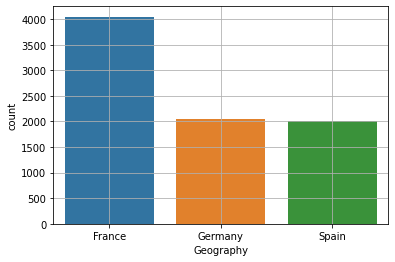

In [27]:
# Verificando a quantidade de clientes em cada país

sns.countplot(data=X_train.join(y_train), x='Geography')
plt.grid()
plt.show()

In [28]:
# Checando a quantidade de clientes por país cadastrado

df_raw['Geography'].value_counts(normalize=True)

France     0.5014
Germany    0.2509
Spain      0.2477
Name: Geography, dtype: float64

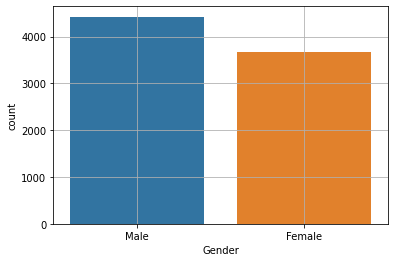

In [29]:
# Quantidade de pessoas por gênero

sns.countplot(data=X_train.join(y_train), x='Gender')
plt.grid()
plt.show()

In [30]:
# Contabilizando clientes por gênero

df_raw['Gender'].value_counts(normalize=True)

Male      0.5457
Female    0.4543
Name: Gender, dtype: float64

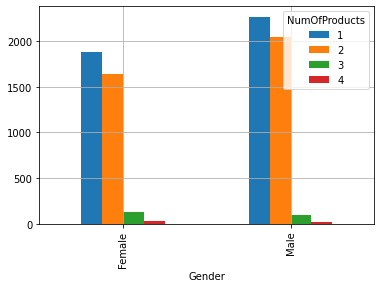

In [31]:
# Consumo dos tipos de serviço oferecidos por gênero

X_train.join(y_train).groupby(['Gender', 'NumOfProducts']).size().unstack().plot(kind='bar')
plt.grid()

Não há diferença de compra dos diferentes serviços entre os gêneros.

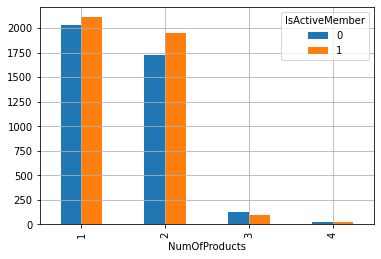

In [32]:
# Clientes ativos e serviços oferecidos

X_train.join(y_train).groupby(['NumOfProducts', 'IsActiveMember']).size().unstack().plot(kind='bar')
plt.grid()

Até a compra de 2 produtos, os membros ativos compram um pouco mais que os clientes não ativos, porém quando chega a 3 produtos, os clientes ativos compram menos.

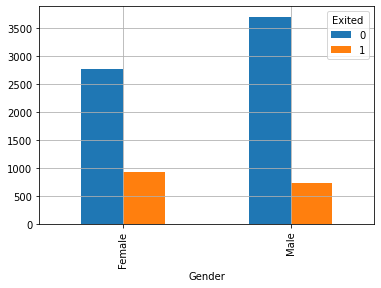

In [33]:
# Churn por gênero

X_train.join(y_train).groupby(['Gender', 'Exited']).size().unstack().plot(kind='bar')
plt.grid()

In [34]:
churn_gender = X_train.join(y_train).groupby(['Gender', 'Exited']).size().unstack()
churn_gender

Exited,0,1
Gender,,
Female,2753,924
Male,3697,726


In [35]:
# Proporção de gênero por churn

churn_gender.iloc[:, 1] / churn_gender.sum(axis=1)

Gender
Female    0.251292
Male      0.164142
dtype: float64

Mulheres dão mais churn.

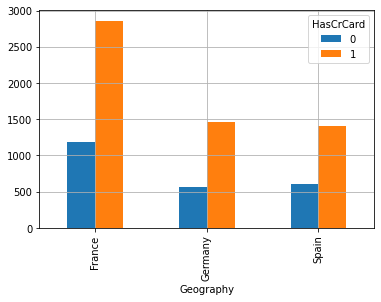

In [36]:
# Uso de cartão de crédito por país

X_train.join(y_train).groupby(['Geography', 'HasCrCard']).size().unstack().plot(kind='bar')
plt.grid()

In [37]:
# Proporção de clientes dos diferentes países com o cartão de crédito

h5 = X_train.join(y_train).groupby(['Geography', 'HasCrCard']).size().unstack()
h5.iloc[:, 1] / h5.sum(axis=1)

Geography
France     0.706377
Germany    0.719961
Spain      0.700248
dtype: float64

A proporção é praticamente a mesma.

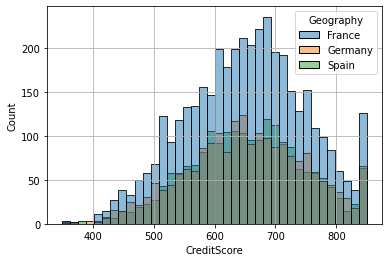

In [38]:
# CreditScore dos clientes dos diferentes países

sns.histplot(X_train.join(y_train), x='CreditScore', hue='Geography')
plt.grid()

In [39]:
X_train[['CreditScore', 'Geography']].groupby('Geography').describe().reset_index()

Geography CreditScore                                                     \
                  count        mean        std    min    25%    50%    75%   
0    France      4046.0  650.727138  97.023465  350.0  583.0  654.0  718.0   
1   Germany      2039.0  651.898970  97.907702  350.0  585.0  651.0  723.0   
2     Spain      2015.0  652.482878  94.167035  358.0  588.0  653.0  717.0   

          
     max  
0  850.0  
1  850.0  
2  850.0

Não foi vista nenhuma diferença entre as distribuições.

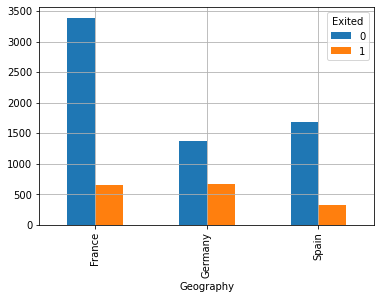

In [40]:
# Churn em cada país

X_train.join(y_train).groupby(['Geography', 'Exited']).size().unstack().plot(kind='bar')
plt.grid()

In [41]:
# Proporção do churn por país

h7 = X_train.join(y_train).groupby(['Geography', 'Exited']).size().unstack()

h7.iloc[:, 1] / h7.sum(axis=1)

Geography
France     0.162383
Germany    0.326140
Spain      0.162779
dtype: float64

Não foi notada nenhuma diferença entre a França e Espanha, no entanto, a Alemanha apresenta maior churn.

# 6. Feature Engineering / Transformação / Pipeline

* Inserindo coluna de gasto por salário

* BalancePerSalary = 'Balance' / 'EstimatedSalary'

In [42]:
# Criando classes para tratar igualmente os dados de treino, teste e validação

from sklearn.base import BaseEstimator, TransformerMixin


class Feature_drop(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.drop(self.cols, axis=1)


class Add_BalancePerSalary(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['BalancePerSalary'] = X['Balance']/X['EstimatedSalary']
        return X

In [43]:
# Criação do pipeline / transformação

fd = Feature_drop(['RowNumber', 'CustomerId', 'Surname']) # Para dropar as colunas

ohe = OneHotEncoder(drop='first', sparse_output=False) # Instanciando para o encoder

ohe_ct = ColumnTransformer([('ohe_ct', ohe, ['Geography', 'Gender'])], remainder='passthrough')

standard_scaler = StandardScaler() # Instanciando para ajustar a escala

pipeline = Pipeline([('drop', fd), ('one_hot', ohe_ct),
                     ('StanderScaler', standard_scaler)])

In [44]:
# Transformando os dados de treino

X_train_tr = pipeline.fit_transform(X_train)


# Transformando os dados de validação

X_val_tr = pipeline.transform(X_val)

In [45]:
# Verificando a separabilidade dos dados com o TSNE

tsne = TSNE(n_components=2, random_state=42)

X_reduced = tsne.fit_transform(X_train_tr)

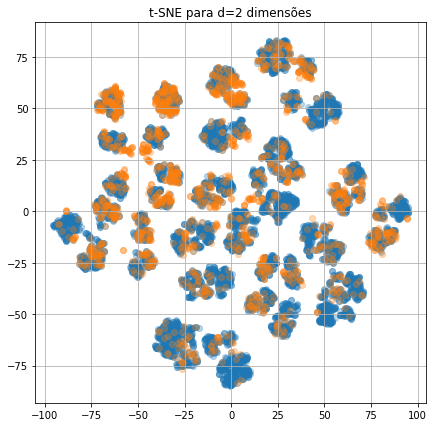

In [46]:
plt.figure(figsize=(7,7))
plt.scatter(X_reduced[y_train == 0, 0], X_reduced[y_train == 0, 1], alpha=0.3)
plt.scatter(X_reduced[y_train == 1, 0], X_reduced[y_train == 1, 1], alpha=0.3)
plt.title('t-SNE para d=2 dimensões')
plt.grid()
plt.show()

Percebe-se, acima, que os dados possuem um indicativo de baixa separabilidade, pois, em duas dimensões, é difícil delimitar as regiões da classe 0 e da classe 1.

# 7. Balanceamento das classes

É possível ver, abaixo, o balanceamento das classes pela remoção dos dados sobrerepresentados (undersampling) e a adição dos dados subamostrados (oversampling).

In [47]:
# Proporção desbalanceada

y_train.value_counts(normalize=True)

0    0.796296
1    0.203704
Name: Exited, dtype: float64

In [48]:
# Verificando perfomace com dados desbalanceados

clf = LogisticRegression(class_weight='balanced', random_state=42)
clf.fit(X_train_tr, y_train)
y_pred = clf.predict(X_val_tr)
y_score = clf.predict_proba(X_val_tr)[:,1]

print(classification_report(y_val, y_pred))
print('AUC: ', np.round(roc_auc_score(y_val, y_score),2))

              precision    recall  f1-score   support

           0       0.89      0.74      0.81       717
           1       0.39      0.66      0.49       183

    accuracy                           0.72       900
   macro avg       0.64      0.70      0.65       900
weighted avg       0.79      0.72      0.74       900

AUC:  0.75


### 7.1 NearMiss (Undersampling)

In [49]:
nm = NearMiss(sampling_strategy=0.5)
X_train_balanced, y_train_balanced = nm.fit_resample(X_train_tr, y_train)

In [50]:
# Checando nova proporção com NearMiss

y_train_balanced.value_counts(normalize=True)

0    0.666667
1    0.333333
Name: Exited, dtype: float64

In [51]:
clf = LogisticRegression(class_weight='balanced', random_state=42)
clf.fit(X_train_balanced, y_train_balanced)
y_pred = clf.predict(X_val_tr)
y_score = clf.predict_proba(X_val_tr)[:,1]

print(classification_report(y_val, y_pred))
print('AUC: ', np.round(roc_auc_score(y_val, y_score),2))

              precision    recall  f1-score   support

           0       0.88      0.71      0.78       717
           1       0.35      0.61      0.44       183

    accuracy                           0.69       900
   macro avg       0.61      0.66      0.61       900
weighted avg       0.77      0.69      0.71       900

AUC:  0.74


### 7.2 SMOTE (Oversampling)

In [52]:
smote = SMOTE(sampling_strategy=0.5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tr, y_train)

clf = LogisticRegression(class_weight='balanced', random_state=42)
clf.fit(X_train_balanced, y_train_balanced)
y_pred = clf.predict(X_val_tr)
y_score = clf.predict_proba(X_val_tr)[:,1]

print(classification_report(y_val, y_pred))
print('AUC: ', np.round(roc_auc_score(y_val, y_score),2))

              precision    recall  f1-score   support

           0       0.89      0.74      0.81       717
           1       0.39      0.65      0.49       183

    accuracy                           0.72       900
   macro avg       0.64      0.69      0.65       900
weighted avg       0.79      0.72      0.74       900

AUC:  0.75


Os resultados do balanceamento não demonstraram melhora, por esse motivo, seguimos com as classes desbalanceadas. A estratégia será ajustar o `class_weight` nos modelos, para atribuir maior prioridade à classe subamostrada.

# 8. Feature selection

Foi utilizado o SelectKBest para selecionar as melhores features, utilizando ANOVA como teste estatístico. Além disso, foi feito um loop para verificar o número ideal de k features.

In [53]:
# Dimensionalidade do X_train_tr

X_train_tr.shape

(8100, 11)

In [54]:
# Lista com o número de features
k_array = np.arange(1,12)

# Lista vazia para armazenar os valores de AUC
auc_array = np.zeros(len(k_array))

for i in range(len(k_array)):
    # Instanciando o SelectKBest
    fs = SelectKBest(score_func=f_classif, k=k_array[i])
    # Colunas selecionadas do treino:
    X_train_selected = fs.fit_transform(X_train_tr, y_train)
    # Colunas selecionadas da validação:
    X_val_selected = fs.transform(X_val_tr)
    
    # Treinando o modelo para avaliar o valor de AUC
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X_train_selected, y_train)
    y_score = clf.predict_proba(X_val_selected)[:,1]
    
    # AUC das K melhores features
    auc_array[i] = roc_auc_score(y_val, y_score)   

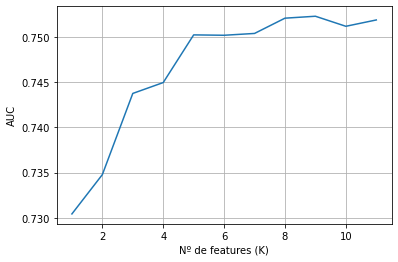

In [55]:
plt.plot(k_array, auc_array)
plt.xlabel('Nº de features (K)')
plt.ylabel('AUC')
plt.grid()
plt.show()

Percebe-se que quanto maior o número de features, maior o AUC. Por esse motivo, foram mantidas as 11 features.

# 8. Treinamento de modelos

* Dummy (baseline)
* Logistic Regression
* SVC
* KNN
* Decision Tree
* Random Forest
* LGBM


Foi utilizado para fins comparativos um modelo dummy, que faz previsões de forma aleatória.

`Observação`: a métrica priorizada será o recall, considerando que consideraria de todas as pessoas que estão em churn, a detecção da maioria delas.

## 8.1 Dummy

In [56]:
dmc = DummyClassifier(strategy='uniform', random_state=42)
dmc.fit(X_train_tr, y_train)
y_pred = dmc.predict(X_val_tr)
y_score = dmc.predict_proba(X_val_tr)[:,1]

print(classification_report(y_val, y_pred))
print('AUC: ', np.round(roc_auc_score(y_val, y_score),3))

              precision    recall  f1-score   support

           0       0.77      0.48      0.59       717
           1       0.18      0.45      0.26       183

    accuracy                           0.47       900
   macro avg       0.48      0.46      0.42       900
weighted avg       0.65      0.47      0.52       900

AUC:  0.5


- A precisão dos dados deu um valor próximo da proporção original dos dados, por se tratar de um modelo Dummy.
- A acurácia deu um valor próximo de 50%
- O AUC, como esperado, deu um valor de 50%.

## 8.2 Logistic Regression

In [57]:
lr = LogisticRegression(C=1.5,class_weight='balanced',random_state=42)
lr.fit(X_train_tr, y_train)
y_pred = lr.predict(X_val_tr)
y_score = lr.predict_proba(X_val_tr)[:,1] # Classe 1

print(classification_report(y_val, y_pred))
print('AUC: ', np.round(roc_auc_score(y_val, y_score),3))

              precision    recall  f1-score   support

           0       0.89      0.74      0.81       717
           1       0.39      0.66      0.49       183

    accuracy                           0.72       900
   macro avg       0.64      0.70      0.65       900
weighted avg       0.79      0.72      0.74       900

AUC:  0.752


Por ser um modelo linear e simples, é possível dizer que é um modelo que não consegue classificar bem os dados. É importante, também, levar em consideração a possível baixa separabilidade dos dados vista anteriormente com o TSNE.

## 8.3 SVC

In [58]:
svc = SVC(kernel= 'rbf',class_weight='balanced', probability=True)
svc.fit(X_train_tr, y_train)
y_pred = svc.predict(X_val_tr)
y_score = svc.predict_proba(X_val_tr)[:,1]

print(classification_report(y_val, y_pred))
print('AUC:', np.round(roc_auc_score(y_val, y_score), 3))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87       717
           1       0.50      0.67      0.57       183

    accuracy                           0.80       900
   macro avg       0.70      0.75      0.72       900
weighted avg       0.83      0.80      0.81       900

AUC: 0.83


## 8.4 KNN

In [59]:
knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(X_train_tr, y_train)
y_pred = knn.predict(X_val_tr)
y_score = knn.predict_proba(X_val_tr)[:,1]

print(classification_report(y_val, y_pred))
print('AUC: ', np.round(roc_auc_score(y_val, y_score),3))

              precision    recall  f1-score   support

           0       0.83      0.97      0.90       717
           1       0.67      0.21      0.32       183

    accuracy                           0.82       900
   macro avg       0.75      0.59      0.61       900
weighted avg       0.80      0.82      0.78       900

AUC:  0.764


## 8.5 Decision Tree

In [60]:
dt = DecisionTreeClassifier(max_depth=5, class_weight='balanced',random_state=42)
dt.fit(X_train_tr, y_train)
y_pred = dt.predict(X_val_tr)
y_score = dt.predict_proba(X_val_tr)[:,1]

print(classification_report(y_val, y_pred))
print('AUC: ', np.round(roc_auc_score(y_val, y_score),3))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86       717
           1       0.48      0.67      0.56       183

    accuracy                           0.79       900
   macro avg       0.69      0.74      0.71       900
weighted avg       0.82      0.79      0.80       900

AUC:  0.822


## 8.6 Random Forest Classifier

In [61]:
rfc = RandomForestClassifier(class_weight='balanced',random_state=42)
rfc.fit(X_train_tr, y_train)
y_pred = rfc.predict(X_val_tr)
y_score = rfc.predict_proba(X_val_tr)[:,1]

print(classification_report(y_val, y_pred))
print('AUC: ', np.round(roc_auc_score(y_val, y_score),3))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       717
           1       0.76      0.38      0.51       183

    accuracy                           0.85       900
   macro avg       0.81      0.68      0.71       900
weighted avg       0.84      0.85      0.83       900

AUC:  0.819


## 8.7 LGBM

In [62]:
lgbm = LGBMClassifier(n_estimators=200, class_weight='balanced',random_state=42)
lgbm.fit(X_train_tr, y_train)
y_pred = lgbm.predict(X_val_tr)
y_score = lgbm.predict_proba(X_val_tr)[:,1]

print(classification_report(y_val, y_pred))
print('AUC: ', np.round(roc_auc_score(y_val, y_score),3))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       717
           1       0.54      0.58      0.56       183

    accuracy                           0.81       900
   macro avg       0.72      0.73      0.72       900
weighted avg       0.82      0.81      0.82       900

AUC:  0.816


O modelo escolhido foi o SVC, pois apresentou o maior AUC.No entanto, há modelos mais rápidos, como o LGBM.

## 8.8 Ajustando os pesos do SVC

Para fins investigativos, foi analisado o ajuste de pesos das classes para melhorar o recall, métrica importante para o problema de negócio.

In [63]:
# Ajustando os pesos das classes no class_weight para melhorar o recall

svc = SVC(kernel= 'rbf',class_weight={0:0.15, 1:0.85}, probability=True)
svc.fit(X_train_tr, y_train)
y_pred = svc.predict(X_val_tr)
y_score = svc.predict_proba(X_val_tr)[:,1]

print(classification_report(y_val, y_pred))
print('AUC:', np.round(roc_auc_score(y_val, y_score), 3))

              precision    recall  f1-score   support

           0       0.93      0.72      0.81       717
           1       0.41      0.78      0.54       183

    accuracy                           0.73       900
   macro avg       0.67      0.75      0.67       900
weighted avg       0.82      0.73      0.75       900

AUC: 0.829


Percebe-se que quando aumenta o recall, diminui a precisão.

# 9. Otimização de hiperparâmetros

In [64]:
svc = SVC(probability=True,random_state=42)

param = {'class_weight' : [{0:1-x, 1:x} for x in np.linspace(0.5, 0.9, 10)],
         'C': np.linspace(1.0, 2.0, 5),
         'kernel':['linear', 'poly', 'rbf', 'sigmoid']
        }


svc_opt = RandomizedSearchCV(estimator=svc, param_distributions= param, n_iter=20, scoring='roc_auc',cv=5)
svc_opt.fit(X_train_tr, y_train)

RandomizedSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
                   n_iter=20,
                   param_distributions={'C': array([1.  , 1.25, 1.5 , 1.75, 2.  ]),
                                        'class_weight': [{0: 0.5, 1: 0.5},
                                                         {0: 0.4555555555555556,
                                                          1: 0.5444444444444444},
                                                         {0: 0.4111111111111111,
                                                          1: 0.5888888888888889},
                                                         {0: 0.3666666666666667,
                                                          1: 0.6333333333333333},
                                                         {0: 0.3222222222222222,
                                                          1: 0.6777777777777778},
                                                         {0: 0.2777777777777778,
                                                          1: 0.7222222222222222},
                                                         {0: 0.2333333333333334,
                                                          1: 0.7666666666666666},
                                                         {0: 0.18888888888888888,
                                                          1: 0.8111111111111111},
                                                         {0: 0.14444444444444438,
                                                          1: 0.8555555555555556},
                                                         {0: 0.09999999999999998,
                                                          1: 0.9}],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   scoring='roc_auc')

In [65]:
# Visualizando melhor estimador

final_svc = svc_opt.best_estimator_
final_svc

SVC(C=1.25, class_weight={0: 0.14444444444444438, 1: 0.8555555555555556},
    probability=True, random_state=42)

In [66]:
# Visualizando o melhor score (AUC)

svc_opt.best_score_

0.849365280714118

In [67]:
# Performance dos dados de validação

y_pred = final_svc.predict(X_val_tr)
y_score = final_svc.predict_proba(X_val_tr)[:,1]

print(classification_report(y_val, y_pred))
print('AUC: ', np.round(roc_auc_score(y_val, y_score),3))

              precision    recall  f1-score   support

           0       0.93      0.71      0.81       717
           1       0.41      0.80      0.55       183

    accuracy                           0.73       900
   macro avg       0.67      0.76      0.68       900
weighted avg       0.83      0.73      0.75       900

AUC:  0.829


Com isso, foi finalizada a avaliação do modelo com os dados de validação.

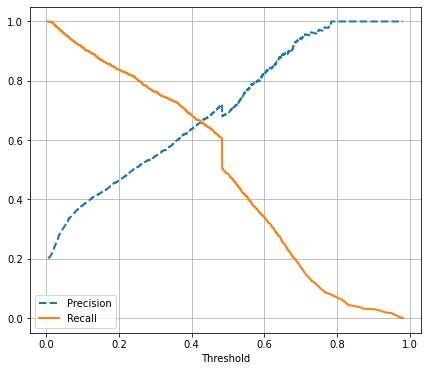

In [68]:
# Precision-recall

y_train_score = final_svc.predict_proba(X_train_tr)

precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_score[:,1])

plt.figure(figsize=(7,6))
plt.plot(thresholds, precisions[:-1], lw=2, ls='--',label='Precision')
plt.plot(thresholds, recalls[:-1], lw=2, label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.grid()
plt.show()

Variação da precisão e do recall com diferentes pontos de corte (thresholds), que representam a probabilidade de o cliente estar em churn ou não. Percebe-se que à medida em que recall aumenta, a precisão cai e vice-versa. Isso é conhecido como tradeoff recall-precision. É importante observar que quando o recall dá 100%, a precisão dá 20%.Esses 20% correspondem à proporção da classe 1 dos dados. Nesse caso, a taxa de falsos positivos será maior. No caso contrário, com a precisão em 100%, o número de falsos negativos aumenta e o de falsos positivos chega a zero.Essa análise pode ser útil para ajustar o recall e precisão, escolhendo o melhor threshold.

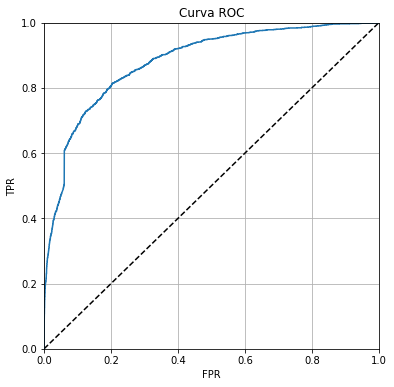

In [69]:
plt.figure(figsize=(6,6))
fpr, tpr, thr = roc_curve(y_train, y_train_score[0:,1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.grid()
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Curva ROC')
plt.show()

# 10. Avaliação final

Foi realizada a avaliação do modelo com os dados de teste.

In [70]:
# Transformação dos dados de teste

X_test_tr = pipeline.transform(X_test)

In [71]:
# Predict dos dados de teste

y_pred = final_svc.predict(X_test_tr)
y_score = final_svc.predict_proba(X_test_tr)[:,1]

print(classification_report(y_test, y_pred))
print('AUC: ', np.round(roc_auc_score(y_test, y_score),2))

              precision    recall  f1-score   support

           0       0.94      0.68      0.79       796
           1       0.40      0.84      0.54       204

    accuracy                           0.71      1000
   macro avg       0.67      0.76      0.67      1000
weighted avg       0.83      0.71      0.74      1000

AUC:  0.85


O threshold é de 50%, mas se for preciso aumentar mais o recall, é interessante diminuir esse valor. Em compensação, vai diminuir a precisão e ter mais falsos positivos. Aumentando o recall, talvez a empresa entrasse em contato com clientes que não estavam em risco de churn, no entanto, as chances de encontrar os clientes que estão realmente em churn iria aumentar. Como será um inconveniente baixo, é a melhor métrica escolhida para priorizar.

## 10.1 Matriz de confusão

<Figure size 576x432 with 0 Axes>

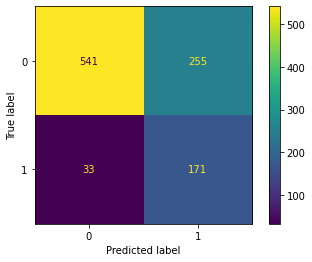

In [72]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize= (8,6))
ConfusionMatrixDisplay(cm).plot()
plt.show()

Os falso negativos deixariam de receber a atenção adequada da empresa com relação ao churn (33). Os verdadeiros positivos (171) receberiam a atenção devida.

## 10.2  Curva de ganho e Lift

In [73]:
# Matriz ranqueada pelo score

rank = pd.DataFrame(y_score, y_test).reset_index()
rank.columns = ['alvo', 'score']
rank = rank.sort_values(by='score', ascending=False)
rank.head()

,alvo,score
215,1,0.976230
953,1,0.953280
676,1,0.940741
548,1,0.884966
126,1,0.877853


In [74]:
# Top 20%

decile = 0.2
index_decile = int(decile * len(rank))

top20 = rank.iloc[:index_decile]
print(f"Taxa do alvo (20%): {(top20['alvo'].sum() / rank['alvo'].sum()):.2f}")

Taxa do alvo (20%): 0.59


<Figure size 576x432 with 0 Axes>

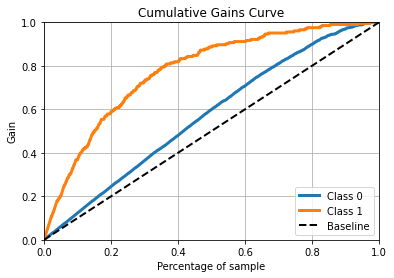

In [75]:
plt.figure(figsize= (8,6))
skplt.metrics.plot_cumulative_gain(y_test, final_svc.predict_proba(X_test_tr))
plt.show()

Acima, é possível ver no eixo X, as porcentagens totais dos dados ranqueados. A taxa do alvo no segundo decil (20%), por exemplo, conseguiu obter 60% dos casos de churn.

<Figure size 576x432 with 0 Axes>

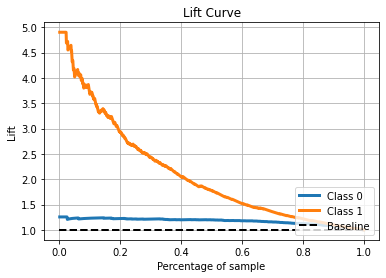

In [76]:
plt.figure(figsize= (8,6))
skplt.metrics.plot_lift_curve(y_test, final_svc.predict_proba(X_test_tr))
plt.show()

É possível observar em que percentis o modelo performa melhor que a baseline com a curva de Lift. Nesse caso, em 20% da base, o modelo treinado no projeto foi aproximadamente 3 vezes melhor que o modelo aleatório (baseline).

In [77]:
clientes = X_test.join(pd.Series(y_score, index=y_test.index, name='score')
                      ).sort_values(by='score', ascending=False)

clientes = clientes.drop('RowNumber', axis=1)

clientes.head(20) # 20 clientes com maior chance de churn

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,score
6172,15656822,Day,568,Germany,Male,43,5,87612.64,4,1,1,107155.40,0.976230
5010,15719508,Davis,575,Germany,Male,49,7,121205.15,4,1,1,168080.53,0.953280
7435,15647898,Russell,610,Spain,Female,50,5,130554.51,3,1,0,184758.17,0.940741
9255,15622033,Rapuluchukwu,847,Germany,Female,41,3,101543.51,4,1,0,16025.17,0.884966
1701,15605279,Francis,792,France,Male,50,9,0.00,4,1,1,194700.81,0.877853
6255,15589017,Chiu,547,Germany,Male,55,4,111362.76,3,1,0,16922.28,0.859260
4869,15781272,Coles,669,France,Male,50,4,149713.61,3,1,1,124872.42,0.854216
2518,15759436,Aksenov,758,France,Female,50,2,95813.76,3,1,1,67944.09,0.849608
5082,15793307,Calabresi,724,Spain,Female,41,4,142880.28,3,0,0,185541.20,0.846407
5950,15806808,Hope,834,Germany,Female,57,8,112281.60,3,1,0,140225.14,0.841067
